### Step 1 - Load Data

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
#import skvideo.io
import os

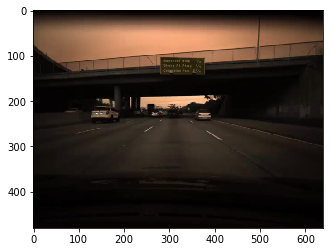

In [7]:
img = cv2.imread('data/images/image-0000001.jpg')
plt.imshow(img)

In [15]:


print(os.listdir("data"))
%matplotlib inline

speed_list = list(map(float,open("data/train.txt").read().splitlines()))
#print(speed_list)
cap = cv2.VideoCapture('data/train.mp4')
import sys
import skvideo.io
cap = cv2.VideoCapture('data/train.mp4')
ret, frame = cap.read()
ret, frame1 = cap.read()
ret, frame2 = cap.read()

#plt.imshow(frame1)
cap.release()

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray1,cmap = 'gray')
print(speed_list[:5])


['test.mp4', 'train.txt', 'processed', 'images']


error: /root/mc-x64-2.7/conda-bld/opencv-3_1482255590695/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7456: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


In [16]:
speed_list = list(map(float,open("data/train.txt").read().splitlines()))

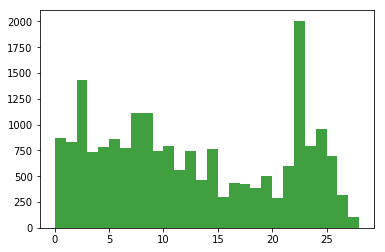

In [84]:
rounded = [round(speed) for speed in speed_list]
mn = 50
mx = 0
for num in rounded:
    mx = max(mx,num)
    mn = min(mn,num)
    
buckets = []
plt.hist(rounded, mx-mn, facecolor='g', alpha=0.75)
plt.show()

In [7]:
def opt_flow(frame1,frame2):
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    gray1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1,gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

#rgb = opt_flow(frame1,frame2)
#plt.imshow(rgb)

### Step 2: Data Augmentation

In [8]:
def rotate(img,angle):
    rows, cols, layers = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

def flip(img):
    return cv2.flip(img,1)

def crop(img,maxh,minh):
    copy = img[:,:,:]
    return copy[minh:maxh,:]

def resize(img,w,h):
    resized_image = cv2.resize(img, (w, h))
    return resized_image

In [9]:
#TODO Data Augmentation'

#Static Strings
read_dir = "data/images/image-"
write_dir = "data/processed/image-"
filetype = ".jpg"

num_digits = '07'
prev = cv2.imread(read_dir+format(1,num_digits)+filetype)

num_frames = 20400

images = []
for i in range(2,num_frames+1):
    img_num = format(i,num_digits)
    
    cur = cv2.imread(read_dir+img_num+filetype)
    cv2.imwrite(write_dir+img_num+filetype,cv2.resize(crop(opt_flow(prev,cur),360,0),(160,90)))
    
    
    prev = cur
    if i % 100 == 0:
        print(i)
    


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

90 160


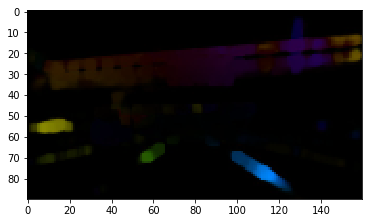

In [87]:
img = cv2.imread('data/processed/optflow-1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(crop(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),360,0),(160,90))#,interpolation = cv2.INTER_LANCZOS4)
rows, cols , layers = img.shape
print(rows,cols)
plt.imshow(img)

In [34]:
num_images = 20399
images = []
for i in range(2,num_images+1):
    images.append(write_dir+format(i,num_digits)+filetype)
    
    

import sklearn
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(images, test_size=0.2)


validation_data = validation_data[:len(validation_data)-1]

print(len(validation_data),len(train_data))

4079 16318


### Step 3: Generator

In [36]:
def get_img_num(filename):
    return int(str(filename).split('-')[1].split('.')[0])


print(get_img_num("a-001.c"))

num_aug = 2

def generator(speed_list,image_names, batch_size=10*num_aug):
    
    angles = np.arange(-6,7,3)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(image_names)
        # batch_size/10 because for each row we add 10 images
        for offset in range(0, len(image_names), int(batch_size/num_aug)):
            batch_lines = image_names[offset:offset+int(batch_size/num_aug)]
                        
            images = []
            speeds = []
            #print("New Batch ---")
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                #print(img_num)
                img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                flipped = flip(img)
                
                images.append(img)
                images.append(flipped)
                speeds.append(speed_list[img_num])
                speeds.append(speed_list[img_num])
                
                """
                for angle in angles:
                    images.append(rotate(img,angle))
                    speeds.append(speed_list[img_num])
                    images.append(rotate(flipped,angle))
                    speeds.append(speed_list[img_num])
                """
                    
                    
            X_train = np.array(images)
            y_train = np.array(speeds)
            yield sklearn.utils.shuffle(X_train, y_train)

            
def valid_gen(speed_list,image_names, batch_size=10):
    
    while 1:
        for offset in range(0, len(image_names), int(batch_size)):
            batch_lines = image_names[offset:offset+int(batch_size)]
            
            images = []
            speeds = []
            
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                
                images.append(img)
                speeds.append(speed_list[img_num])
            
            X_valid = np.array(images)
            y_valid = np.array(speeds)
            yield sklearn.utils.shuffle(X_valid, y_valid)
            
            
    

1


In [37]:


#X_data,y_data = next(train_generator)
#print(X_data.shape,y_data.shape)
#plt.imshow(X_data[0])
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2

train_generator = generator(speed_list,train_data)
validation_generator = generator(speed_list,validation_data)
input_shape = (90,160,3)

In [ ]:
input_shape = (90,160,3)
model = Sequential()

model.add(Lambda(lambda x: x / 255 - 0.5, input_shape = input_shape))
#model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample = (2,2),activation = "elu"))
model.add(Convolution2D(36,5,5,subsample = (2,2),activation = "elu"))
model.add(Convolution2D(48,5,5,subsample = (2,2),activation = "elu"))
model.add(Convolution2D(64,3,3,activation = "elu"))
model.add(Convolution2D(64,3,3,activation = "elu"))

model.add(Flatten())
model.add(Dense(100 , activation='elu'))
model.add(Dense(50,  activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=10)

model.save('models/nvidia.h5')

Epoch 1/10
32620/32636 [============================>.] - ETA: 0s - loss: 93.9467   

In [26]:

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dense(100 , activation='elu'))
model.add(Dense(50,  activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=20)
model.save('models/comma.h5')


Epoch 1/20
21540/32638 [==================>...........] - ETA: 21s - loss: 66.7841  

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/carnd/anaconda3/envs/ana3/lib/python3.4/threading.py", line 911, in _bootstrap_inner
    self.run()
  File "/home/carnd/anaconda3/envs/ana3/lib/python3.4/threading.py", line 859, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carnd/anaconda3/envs/ana3/lib/python3.4/site-packages/keras/engine/training.py", line 433, in data_generator_task
    generator_output = next(generator)
  File "<ipython-input-23-712581c29b69>", line 23, in generator
    img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
cv2.error: /root/mc-x64-2.7/conda-bld/opencv-3_1482255590695/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7341: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor




Exception: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None